In [1]:
import pandas as pd
import matplotlib.colors as mplc
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import stats
import numpy as np
import seaborn as sns

In [2]:
# %matplotlib inline
# activate plot theme
# import qeds
# qeds.themes.mpl_style();

TODO: talk about kiva as an organization, this dataset,
structure of notebook

Kiva is a non-profit organization that hosts a platform, kiva.org, to crowdfund loans to individuals and groups
in underdeveloped regions who otherwise may not have had access to capital. They provide a rich dataset of historical loans from 2006 to 2019.

In this notebook, we will first explore the dataset to glean insights and deeper understanding about the platform.

We will then consider the following questions from an individual lender's point of view:
1. How the value of a lump sum of money placed into the platform changes over time
2. The expected personal loss of making a single loan, and then withdrawing any repayment as soon as possible.

Finally, we will attempt to use machine learning models to predict which loans will get funded, and which will get fully repaid.

In [57]:
# Source: https://www.kiva.org/build/data-snapshots
loans_raw = pd.read_csv("datasets/loans_big.csv", parse_dates=["POSTED_TIME","PLANNED_EXPIRATION_TIME","DISBURSE_TIME","RAISED_TIME",])

In [4]:
loans_raw.dropna().head(1)

,LOAN_ID,LOAN_NAME,ORIGINAL_LANGUAGE,DESCRIPTION,DESCRIPTION_TRANSLATED,FUNDED_AMOUNT,LOAN_AMOUNT,STATUS,IMAGE_ID,VIDEO_ID,...,LENDER_TERM,NUM_LENDERS_TOTAL,NUM_JOURNAL_ENTRIES,NUM_BULK_ENTRIES,TAGS,BORROWER_NAMES,BORROWER_GENDERS,BORROWER_PICTURED,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL
77657,807094,GUSTAVO,Spanish,Gustavo es soltero y vive con sus padres en La...,Gustavo is single and lives with his parents i...,500.0,500.0,funded,1745738.0,3002.0,...,20.0,17,2,1,"user_favorite, user_favorite, user_favorite",GUSTAVO,male,true,monthly,field_partner


In [5]:
min_date = loans_raw["POSTED_TIME"].min()
max_date = loans_raw["POSTED_TIME"].max()
print(f"The dataset contains {len(loans_raw)} loans in the date range {min_date} to {max_date}.")

The dataset contains 1682790 loans in the date range 2006-04-16 07:10:50+00:00 to 2019-02-25 04:12:27+00:00.


We will first explore the quality of the data and see if there will be any issues with missing data.

In [105]:
print(loans_raw.isnull().sum())

            LOAN_ID  FUNDED_AMOUNT   LOAN_AMOUNT      IMAGE_ID     VIDEO_ID  \
count  1.682790e+06   1.682790e+06  1.682790e+06  1.638581e+06   847.000000   
mean   8.570015e+05   7.837114e+02  8.246249e+02  1.763180e+06  2565.658796   
std    4.929807e+05   1.067856e+03  1.120753e+03  8.559269e+05   953.990228   
min    8.400000e+01   0.000000e+00  2.500000e+01  2.410000e+02     7.000000   
25%    4.312492e+05   2.750000e+02  3.000000e+02  1.102599e+06  2252.500000   
50%    8.577985e+05   5.000000e+02  5.000000e+02  1.850590e+06  2780.000000   
75%    1.282309e+06   9.250000e+02  1.000000e+03  2.505611e+06  3244.500000   
max    1.713595e+06   1.000000e+05  1.000000e+05  3.092166e+06  3953.000000   

       CURRENCY_EXCHANGE_COVERAGE_RATE    PARTNER_ID   LENDER_TERM  \
count                     1.345464e+06  1.664465e+06  1.682766e+06   
mean                      1.133567e-01  1.578132e+02  1.310918e+01   
std                       3.401862e-02  9.559313e+01  7.389155e+00   
min     

As you can see, although there are some missing cells, the core data relating to the loans themselves are complete. Although cells relating to currencies are listed, investigating a sample revealed that all loan amounts are in USD.

We will proceed by investigating some basic questions about the loans.


What are these loans going towards?

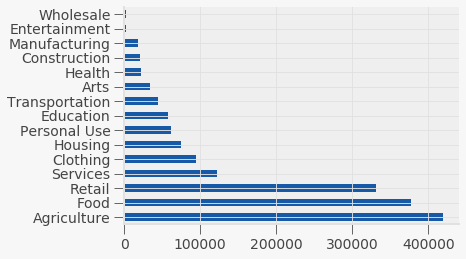

In [21]:
sectors = loans_raw["SECTOR_NAME"].value_counts()
sectors.plot.barh()

What about if we get slightly more granular?

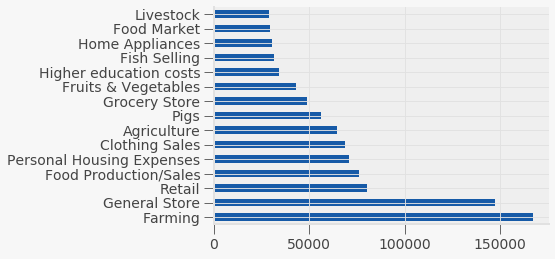

In [22]:
activities = loans_raw["ACTIVITY_NAME"].value_counts().nlargest(15)
activities.plot.barh()

As you can see, the most popular reasons for loans are to help small businesses, such as farming and local retail.

What does the distribution of loan amounts look like?

Text(0.5, 0, 'Loan Amounts in USD')

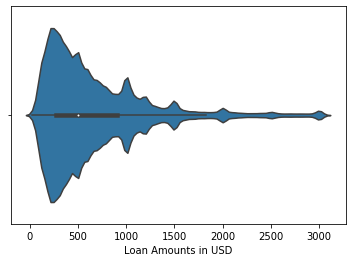

In [100]:
amounts = loans_raw['LOAN_AMOUNT']

# Remove outliers to be able to view amounts at a reasonable scale.
# These outliers are quite rare, but some have extremely large amounts, skewing the image.
z = np.abs(stats.zscore(amounts))
filtered_amounts = amounts[(z < 2)]

ax = sns.violinplot(x=filtered_amounts)
ax.set_xlabel("Loan Amounts in USD")

In [ ]:
We can see that the most common loan amount is 250 USD, though 500 and 1000 are both more popular than surrounding amounts.

How many people tend to contribute to each loan?

8     78933
1     72962
9     72353
7     72134
5     69761
      ...  
73     1814
75     1741
76     1687
77     1600
78     1520
Name: NUM_LENDERS_TOTAL, Length: 79, dtype: int64


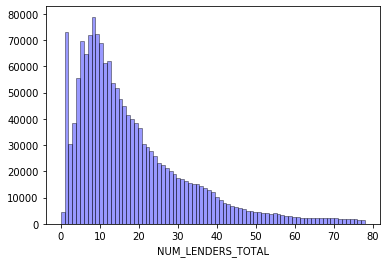

In [103]:
lenders = loans_raw["NUM_LENDERS_TOTAL"]
z = np.abs(stats.zscore(lenders))
filtered_lenders = lenders[(z < 2)]

print(filtered_lenders.value_counts())

sns.distplot(filtered_lenders, hist=True, kde=False, 
             bins=len(filtered_lenders.value_counts()), color = 'blue',
             hist_kws={'edgecolor':'black'})

We see that the distribution is centered around 8 lenders, with a long right tail. However, we can also see that a significant number of loans were funded by only a single person.

The loans are not guaranteed to get fully funded. How many do not?

In [24]:
loan_diffs = amounts - loans_raw["FUNDED_AMOUNT"]
loan_diffs = loan_diffs[loan_diffs != 0]
percent_unfunded = ((loan_diffs.count() / amounts.count()) * 100).round(1)
print(f"{percent_unfunded}% of loans do not get fully funded.")

unfunded_asking_amounts = amounts[loan_diffs.index]
unfunded_ratios = loan_diffs / unfunded_asking_amounts
how_much_funded = (unfunded_ratios.mean() * 100).round(1)
print(f"Of those, the mean amount funded is {how_much_funded}% of the ask.")

5.1% of loans do not get fully funded.
Of those, the mean amount funded is 56.4% of the ask.


Once the loans are distributed, there is no guarantee that they will be repaid. How many do not?

Unfortunately, there was no information to answer this question in the original dataset. We instead turn to a previously supplied dataset of 5000 randomly sampled loans with their repayment details, taken from https://stat.duke.edu/resources/datasets/kiva-loans

In [4]:
## TODO: if time, investigate using graphql with original dataset 
repayments = pd.read_excel("datasets/loan_repayment_samples.xlsx")
# basket_amount was all n/a, video.youtube_id was not used
repayments = repayments.drop(["basket_amount", "video.youtube_id"], axis=1)

In [104]:
print(repayments.describe())

       terms.loan_amount  journal_totals.entries   delinquent        amount  \
count       42103.000000            42073.000000  1920.000000  42078.000000   
mean          680.563339                1.411452     1.563151     65.265536   
std           567.361911                1.523893     4.904250     87.019130   
min            25.000000                1.000000     1.000000   -504.000000   
25%           325.000000                1.000000     1.000000     19.380000   
50%           550.000000                1.000000     1.000000     48.000000   
75%           925.000000                2.000000     1.000000     83.000000   
max         10000.000000               83.370000    44.250000   1942.600000   

         payment_id  local_amount  rounded_local_amount           lat  \
count  4.207800e+04  4.207800e+04          4.207800e+04  42078.000000   
mean   4.499265e+07  5.516449e+04          5.394330e+04      9.440538   
std    4.091286e+07  2.552949e+05          2.166499e+05     16.679844

In [51]:
# This dataset has a row for each individual payment; aggregate these into a single row per loan

grouped_repayments = repayments.groupby("id", as_index=False).agg(lambda x: x.tolist())

50.0


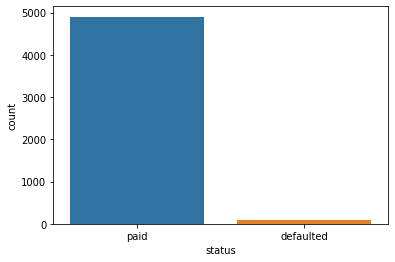

In [66]:
# Get the payment status of the loan
grouped_repayments["status"] = grouped_repayments["status"].agg(lambda x: "defaulted" if "defaulted" in x else "paid")

sns.countplot(x="status", data=grouped_repayments)

In [74]:
status_counts = grouped_repayments["status"].value_counts()
default_ratio = ((status_counts["defaulted"] / len(grouped_repayments)) * 100).round(1)
print(f"{default_ratio} % of loans in this sample have defaulted.")

2.0 % of loans in this sample have defaulted.


What are the gender ratios of those receiving loans? Those giving loans?

([<matplotlib.patches.Wedge at 0x185f56ba508>,
 [Text(0.8900657361465263, 0.6463613427007702, 'males'),
  Text(-0.8900657966632387, -0.6463612593667989, 'females')])

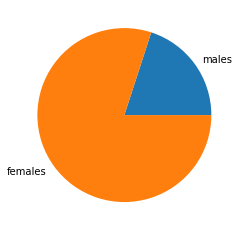

In [81]:
genders = loans_raw["BORROWER_GENDERS"].dropna()
females = 0
males = 0

# The gender entries include all recipients as a comma separated string, so a simple value_counts will not work.
for entry in genders:
    recipients = entry.split(", ")
    for gender in recipients:
        if gender == "female":
            females += 1
        else:
            males += 1
            
fig, ax = plt.subplots()
ax.pie(x=[males, females], labels=["males", "females"])

In [ ]:
## TODO import lenders dataset to answer

In [ ]:
# TODO: investigate further into columns such as funded_time, borrower_genders to decide whether some rows should be dropped.

In [ ]:
## TODO remove if not going to use
# import requests
# base_url = 'https://api.kivaws.org/graphql?query='

# graphql_query = "{lend {loan (id: 1568001){id name}}}"

# r = requests.post(base_url+ graphql_query )
# r.json()

Exploratory data analysis

In [ ]:
# amounts = loans_raw["loan_amount"]

# # Remove the very large loan amounts for plotting
# z = np.abs(stats.zscore(amounts))
# print(np.where(z > 6))

# amounts = amounts[(z < 10)]
# normalized_amounts = (amounts - amounts.mean()) / amounts.std()

# fig, ax = plt.subplots()
# normalized_amounts.plot(
#     kind="hist", y="Loan amounts", color=(244/255, 77/255, 24/255),
#     bins=23, legend=False, density=True, ax=ax
# )

In [ ]:
# TODO: PLOT LOAN AMOUNTS, SECTORS, COUNTRIES, TERMS, POSTED_TO_DISTRIBUTED, REPAYMENT INTERVALS, GENDERS


In [ ]:
# TODO: plot frequency of loans over time in sample
timeseries = loans_raw.set_index("POSTED_TIME")
# timeseries = timeseries.set_index(timeseries.index.to_pydatetime())
# fig, ax = plt.subplots(figsize=(12, 4))
# ax.plot()
# plt.plot(timeseries.index.to_pydatetime())

In [ ]:
# TODO: consolidate uses of loans by string matching and plot

In [ ]:
# TODO: estimate pdv of loans to infer how much people are "giving away" in these loans

In [ ]:
# TODO: create heatmap of loan countries/regions in sample

In [ ]:
# TODO: compare loan country distribution to poverty levels from another dataset
# (the more granular the better, original dataset has coordinates)


In [ ]:
# TODO: use Kiva's API to get the loan statuses of loans in sample (need to test first to see if viable)
# or maybe see if the sample loans are contained in the large dataset



In [ ]:
# TODO: make ML models to try to predict whether loans will be a) funded b) repaid
